In [ ]:
#|hide
## If running in colab, set things up with:
# !pip install -q tglcourse
# !git clone https://github.com/johnowhitaker/tglcourse
# %cd tglcourse

# Lesson 2: Gradient Descent and Optimization

In [ ]:
#|hide
import torch
import torchvision
import numpy as np
import IPython.display as ipd
from matplotlib import pyplot as plt
from tglcourse.utils import *
from PIL import Image

In [ ]:
#|echo: false
ipd.display(ipd.IFrame(src="https://www.youtube.com/embed/LwBB6YYr-Ro", width="560", height="315"))

If you'd prefer a much longer video with more explanation, here is a [fairly rough live notebook walkthrough](https://youtu.be/R19vbfTtmkc).

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/johnowhitaker/tglcourse/blob/main/02_Optimization.ipynb)

## Gradient Descent

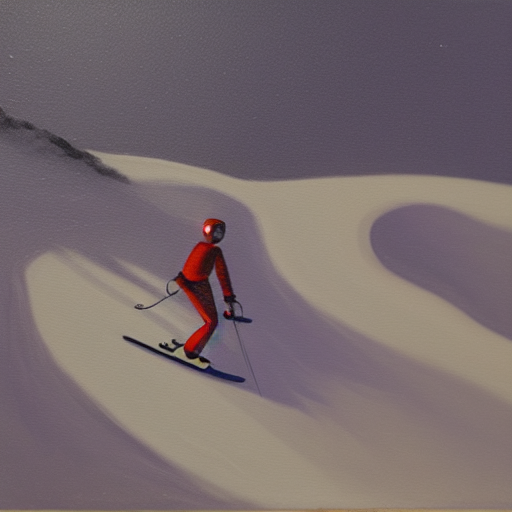

In [ ]:
#| echo: false
load_image_pil('images/An_oil_painting_of_a_robot_skiing_down_a_curved_slope.png')

Lets consider the following situation. Say we have:<br>
- A function (could be a neural net, could be the equation for a straight line...) that takes some input(s) and produces some output(s) based on a set of parameters - let's call them `w`. <br>
- Some measure of how well this function performs. Maybe this is how poorly the function describes some pattern in your data, or how well a network does in a classification task. Let's call this measure the `loss`, where the goal is to make this as small as possible.<br>

The question is often 'how do we find a set of parameters that gives the best possible result?'. There are a few ways we could try to solve this. The most basic might be:<br>
- Try all possible values for all parameters<br>
- Randomly guess and keep the best<br>

Clearly both of these have some major flaws, and when we're dealing with thousands or millions of parameters there is no way you could try all possible combinations. So, we need a smarter approach.

### The Gradient Descent Algorithm

What if we could start from some set of parameters, and then see how to modify them slightly such that we get an improvement? Ideally, for each parameter we'd like to know what happens to the loss when we tweak that parameter slightly up or down. Formally, we'd like to know the **gradient of the loss with respect to that parameter**. You can think of the gradient as telling us which direction to move to get the biggest increase (or decrease if we go in the opposite direction).

IF we can find these gradients, then a sensible method for finding a good set of parameters to solve a given problem would be
1. Start with some random parameters
2. Find the gradient of the loss with respect to each parameter
3. Update each parameter such that you move some small amount in the direction of steepest descent
4. Go back to step 2, finding the gradients based on the new parameter values and repeat all this a bunch of times.

This is the gradient descent algorithm in a nutshell :) Let's do an example, where we'll create some data that roughtly follows a trend and try to approximate that trend with a straight line, which will be specified by two parameters. 

### Creating an Example Problem

Here's our 'training' data, with a single input (x) and a single target (y):

<matplotlib.collections.PathCollection>

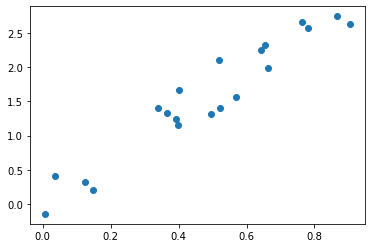

In [ ]:
# Creating some data:
x = torch.rand(20)
y = 3*x + 0.2 + torch.randn(20)*0.3 # y = ax + b + noise
plt.scatter(x, y) # It's always helpful to visualize what's going on wherever possible.

### 2.3 Defining our loss

We can describe a line as a function `y = ax + b` where a and b are our parameters. Take a look at the two lines shown here:

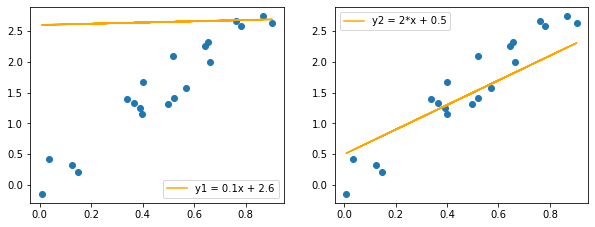

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3.6))
axs[0].scatter(x, y)
axs[0].plot(x, 0.1*x + 2.6, label='y1 = 0.1x + 2.6', c='orange')
axs[0].legend()
axs[1].scatter(x, y)
axs[1].plot(x, 2*x + 0.5, label='y2 = 2*x + 0.5',  c='orange')
axs[1].legend();

Clearly one does a better job than the other at describing the trend in this data. But how do we quantify this? There are several measures used in this sort of case, with a popular one being the 'Root Mean Squared Error'. It sounds intimidating, but all we do is take the errors (how far each point is from the line), square them, sum the squares and then take the square root of that. More points further from the line -> higher errors (squaring takes care of any minus signs that would otherwise cause issues with points above/below the line) -> a higher final value for the RMSE. So lower is better. This is our loss function. 

Here's one way to implement this in code (there are also built-in functions for this and many other ways you could write it):

In [ ]:
def rmse(y, y_pred):
    return torch.mean((y-y_pred)**2)**0.5 # See how many ways you can write this

Using this loss function, we can quantify how well those lines match the data:

In [ ]:
y1 = 0.1*x + 2.6
y2 = 2*x + 0.5
print('RMSE for y_hat1 = 0.1x + 2.6:', rmse(y, y1))
print('RMSE for y_hat2 = 2*x + 0.5:', rmse(y, y2))

RMSE for y_hat1 = 0.1x + 2.6: tensor(1.3639)
RMSE for y_hat2 = 2*x + 0.5: tensor(0.3955)


The second line has a lower loss, and is therefore a better fit. Tweak the parameters and see if you can do even better.

**THINK**: What is your thought process as you try this? Are you doing something like the gradient descent described earlier?

### 2.4 Calculating Gradients

So, how do we find the gradients we keep talking about? If you're good at differentiation, you can look at a function and figure them out analytically. But this quickly breaks down when the function is complex or involves many steps. Fortunately, PyTorch does something called automatic differentiation, where it can keep track of every operation that happens to a tensor. It builds something called a computational graph, and when you want to calculate the gradients with respect to some final result you can simply call .backward() and PyTorch will trace the path back through this graph filling in the gradients at each step. We won't go too deep into this, but here's a simple example:

In [ ]:
# Some operations to demonstrate autograd
a = torch.tensor(5.7)
a.requires_grad = True # This is important - by default PyTorch won't track gradients

b = 5*a + 2

c = torch.sin(2*b+0.1)

c

tensor(-0.9871, grad_fn=<SinBackward0>)

Notice that `grad_fn` bit there? Because c depends on something (b) that depends on a tensor that requires_grad (a), PyTorch keeps track of the function needed to calculate the gradients. We could then see the gradient of c with respect to a with:

In [ ]:
c.backward() # Tell pytorch to propagate the gradients backwards down the chain of operations
a.grad # See the resulting gradient

tensor(-1.6036)

The derivative of c with respect to a is (10\*cos(10\*(a+0.41)) - plugging in a=5.7 we see that this does indeed give the answer dc/da = -1.603. This is quite magical - we can chain complex functions together and as long as eveything is differentiable we can rely on PyTorch to be able to work backwards and give us all the gradients we need.

### Gradient Descent on our Toy Example

Let's get back to that example we were playing with, trying to find the parameters for a line that best describes the trend in our data. 

We create our parameters `w` (initialized to 2 random floats) and tell pytorch to keep track of gradients. 

Then, in a loop, we repeatedly find the loss, find the gradients (`loss.backward()`) and update the parameters accordingly. We could do this ourselves but PyTorch provides an optimizer that handles the update for us - torch.optim.SGD. The learning rate `lr` determines how small of a step we take at each iteration. 

Once the loop has finished running, we plot the losses and see that we are indeed getting better and better over time.

loss at step 0 : tensor(1.0562, grad_fn=<PowBackward0>)
loss at step 20 : tensor(0.5021, grad_fn=<PowBackward0>)
loss at step 40 : tensor(0.3565, grad_fn=<PowBackward0>)
loss at step 60 : tensor(0.2702, grad_fn=<PowBackward0>)
loss at step 80 : tensor(0.2418, grad_fn=<PowBackward0>)


Text(0.5, 1.0, 'Loss over time')

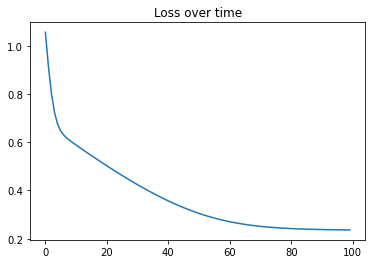

In [ ]:
w = torch.rand(2) # Our parameters
w.requires_grad = True # Explain

optimizer = torch.optim.SGD([w], lr=0.2) # Research: What does SGD stand for?

losses = [] # Keep track of our losses (RMSE values)
ws = [] # Keep track of the values we predicted

for i in range(100):

    # Reset everything related to gradient calculations
    optimizer.zero_grad()

    # Get our outputs
    y_hat = w[0]*x + w[1] 

    # Calculate our loss
    loss = rmse(y, y_hat)

    # Store the loss and a copy of the weights for later
    losses.append(loss.detach().item())
    ws.append(w.clone().detach().numpy())

    # Print out updates ever few iterations
    if i % 20 == 0:
        print('loss at step', i, ':', loss)

    # Backpropagate the loss and use it to update the parameters
    loss.backward() # This does all the gradient calculations
    optimizer.step() # The optimizer does the update. 


plt.plot(losses)
plt.title('Loss over time')

Our random parameters have been updated 100 times and are now close to as good as they can possibly get:

In [ ]:
w # View the learned parameters

tensor([3.0881, 0.0810], requires_grad=True)

In [ ]:
w.grad # We can see the gradients of the loss with respect to w (now small since we're close to optimum)

tensor([-0.0208,  0.0105])

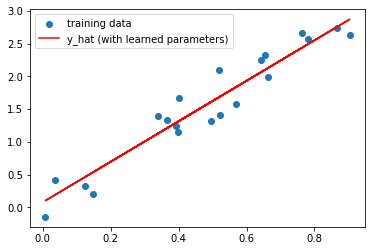

In [ ]:
# Plot predictions with these parameters
plt.scatter(x, y, label='training data')
y_hat = w[0]*x + w[1]
plt.plot(x, y_hat.detach(), c='red', label='y_hat (with learned parameters)')
plt.legend();

Since we only have two parameters, we can make a plot that shows the loss for every combination of values within some range. We'll plot the values of the parameters during the optimization loop above as points, and you can see how they slowly 'move' towards a point with lower loss:

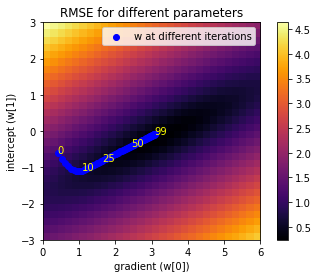

In [ ]:
#|hide
w1, w2 = torch.meshgrid(torch.arange(0, 6, 0.2), torch.arange(-3, 3, 0.2), indexing='ij') # Grids with both parameters
width, height = w1.shape

# Calculating y_hat for each seat of params and then the resulting RMSEs
y_preds = x.unsqueeze(0).expand(width*height, -1) * w1.flatten().unsqueeze(0).expand(20, -1).T + w2.flatten().unsqueeze(0).expand(20, -1).T
rmses = torch.mean((y.unsqueeze(0).expand(width*height, -1)-y_preds)**2, dim=1)**0.5

# Showing the loss landscape
plt.imshow(rmses.reshape(width, height).T, cmap='inferno', extent=[0, 6, -3, 3])
plt.colorbar()
plt.title('RMSE for different parameters')
plt.xlabel('gradient (w[0])')
plt.ylabel('intercept (w[1])')

# Showing the path we took over time. We need x, -y due to the way imshow works 
plt.scatter([w[0] for w in ws], [-w[1] for w in ws], c='blue', label='w at different iterations')
for i in [0, 10, 25, 50, 99]:
  plt.annotate(i, (ws[i][0], -ws[i][1]), c='yellow')
plt.legend()
plt.show()

Instead of optimizer.step(), we could do `w -= w.grad * 0.2` where 0.2 is the learning rate and the minus sign is because we want to move in the direction that reduces loss (so opposite to the steepest gradient). 

**EXERCISE**:: Try this and confirm for yourself that this works. (You'll need `with torch.no_grad(): w -= w.grad * 0.2` or PyTorch will complain - try it without first for a glimpse at an error you'll likely meet a few more times in life ;)

**THINK**: Does this make sense? Are there any issues? What happens when the gradients are small? What happens when our step size (learning rate) is too high?

**THINK**: What kinds of problems can we solve with this tool? Can you think of examples? What are the limitations?

## Optimization Methods

Gradient Descent (or Stochastic Gradient Descent, which is just GD on batches of data rather than the full dataset) is just one optimization method. There are many improvements that can be made. If you're interested, here is a great rundown of the many alternatives that are used today: https://ruder.io/optimizing-gradient-descent/

One useful idea that is bundled with optimizers in PyTorch is that of regularization. It's a large topic, but in essence regularization is concerned with smoothing things out and simplifying models or parameter sets by avoiding any values that are too extreme.

At some point I hope to add another notebook for exploring this, for now just remember that there are lots of different choices of optimizer available in PyTorch and they can be fun to experiment with and compare.


## Demo Time!

We've solved the toy problem above with optimization. What else can we do with this? Well, for one thing this same approach is used to train pretty much all neural networks in use today! We'll look at how that works in a future lesson. For now, you might enjoy checking out the bonus notebook 'Fun With Generators and Losses' where we look at a number of 'generators' (functions with parameters we can optimize that produce and image) and a number of 'losses' which we can use to get different effects. For example, here's how we'd optimize a network based on sinusoidal functions to match a text description (leaning on some magical algorithms like CLIP which we haven't covered yet):

In [ ]:
from tglcourse.generation_utils import SirenGenerator, CLIPLossToTargets, optimise
import torch

In [ ]:
#|eval:false
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gen = SirenGenerator().to(device)
clip_loss_fn = CLIPLossToTargets(text_prompts=['A painting of a jellyfish by a coral reef'], n_cuts=32, device=device)
optimizer = torch.optim.Adam(gen.parameters(), lr=0.01)
optimise(gen, [clip_loss_fn], optimizer=optimizer, n_steps=50)

If you dig into the code for that `optimise` function you'll see that it is essentially just the same as the optimization loop we made earlier in this notebook! 

## Where next

The bonus notebook 'Fun with Generators and Losses' and the accompanying [video](https://youtu.be/rO5nmpniYkU) are fairly complimentary to this notebook. The video especially shows a very high-level view of optimization and how this single idea underlies a TON of deep learning applications. Lots of the code in the notebook will look unfamiliar since we haven't covered many of the building blocks in this course yet - give it a skim now and then re-read it again after, say, lesson 5.

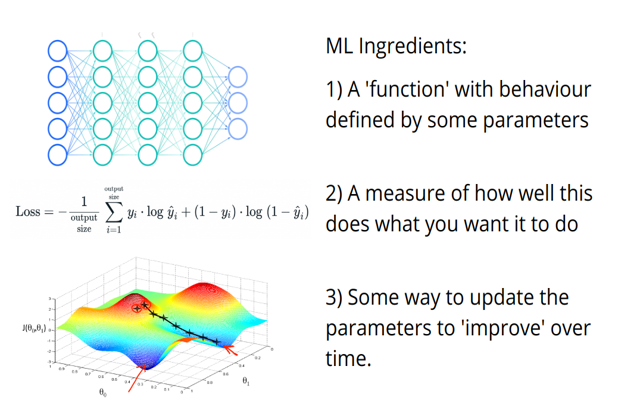

In [ ]:
#| echo: false
load_image_pil('images/ml_ingredients.png', size=(640, 400))

Two other ideas for how to keep busy until the next lesson: <br>
- Check out [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0) where Andrej Karpathy trains a neural network from scratch, including implementing the gradient calculations and things which we've been offloading to PyTorch. Great if you like to see things built from the bottom up!
- Go back through this notebook and try to tweak as many things as you can. Re-implement the loss calculation without peeking at the RMSE function, change the starting values of the parameters we're optimizing, try a different optimizer (see the torch documentation) or play with changing the learning rate. Can you find a way to get a good solution with fewer steps? Does it ever go wrong and give crazy results or errors? 
- Look for code online for training a neural network in PyTorch. Can you spot the optimization loop? More generally, can you find examples online of deep learning tasks and identify the three ingredients shown above in each case?

## A Dose Of Ethics: Objectives Matter

Let's say you want to predict recidivism rates (how likely a person is to commit a crime once released). What should your loss function be? Perhaps you can look at past cases, see who was re-arrested and train a model to maximise accuracy when predicting this. After all, arrests are a good way to measure crimes, right? But what if some neighbourhoods have more police presence, or the officers are more likely to arrest some subset of the population? If the measure is biased, the algorithm will be biased, and a biased algorithm can mean unfair outcomes. [This is a big problem for risk prediction software](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) and is one example of the kinds of issues that can arise when you pick the wrong metric to optimize. 

From content recommendation systems pushing outrage-inducing clickbait to maximise 'engagement', to chatbots spewing hate-speech, failures to consider the consequences of optimizing towards a single metric abound. We're going to have a lot of fun with optimization, but remember: with great fun... comes great responsibility. 

Page stats: Total Hits: [![HitCount](https://hits.dwyl.com/johnowhitaker/tglcourse.svg?style=flat-square&show=unique)](http://hits.dwyl.com/johnowhitaker/tglcourse)
Page visitors:
![visitor badge](https://page-views.glitch.me/badge?page_id=tglcourse.l02)